In [1]:
import pandas as pd
import numpy as np
import requests
import io
import time
import json
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import statistics
import cartopy.geodesic as cgeo
import json


# Haversine formula for calculating the distance between two points on a sphere
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in km
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Vectorizing the Haversine formula
vec_haversine = np.vectorize(haversine)


In [191]:
BLITZ_DIST = 100

lat=50.
lon=9.

sitename = 'Frankfurt am Main'


In [192]:
json_file = '/home/kakl/vanice/data/fr_wind-turbines.geojson'

with open(json_file) as f:
    data = json.load(f)
windturbines = pd.json_normalize(data,'features')

windturbines['lon'] = windturbines['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0])
windturbines['lat'] = windturbines['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1])


In [193]:
# Reduction of wind-turbines points

windturbines['lonRad']=np.radians(windturbines.lon)
windturbines['latRad']=np.radians(windturbines.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
windturbines['DlonRad']=lonRad-windturbines.lonRad
windturbines['DlatRad']=latRad-windturbines.latRad
windturbines['a']=np.sin(windturbines.DlatRad/2.)**2. + np.cos(windturbines.latRad) * np.cos(latRad) * np.sin(windturbines.DlonRad/2.)**2.
windturbines['km'] = 2. * np.arcsin(np.sqrt(windturbines.a))*6378.
windturbines = windturbines.loc[windturbines['km'] <= BLITZ_DIST]
windturbines.reset_index(inplace=True)

In [194]:
json_file = '/home/kakl/vanice/data/fr_towers-masts.geojson'

with open(json_file) as f:
    data = json.load(f)
towers = pd.json_normalize(data,'features')

towers['lon'] = towers['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0])
towers['lat'] = towers['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1])


In [195]:
# Reduction of distant tall structures

towers['lonRad']=np.radians(towers.lon)
towers['latRad']=np.radians(towers.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
towers['DlonRad']=lonRad-towers.lonRad
towers['DlatRad']=latRad-towers.latRad
towers['a']=np.sin(towers.DlatRad/2.)**2. + np.cos(towers.latRad) * np.cos(latRad) * np.sin(towers.DlonRad/2.)**2.
towers['km'] = 2. * np.arcsin(np.sqrt(towers.a))*6378.
towers = towers.loc[towers['km'] <= BLITZ_DIST]


In [196]:
json_file = '/home/kakl/vanice/data/tall.geojson'

# Rekurzivní funkce pro získání prvního ne-pole prvku
def vyber_prvni_nevnoreny_prvek(hodnota):
    if isinstance(hodnota, list):
        # Pokud je první prvek listu další list, pokračujeme rekurzivně
        return vyber_prvni_nevnoreny_prvek(hodnota[0])
    else:
        # Vrátíme první prvek, který není list
        return hodnota

# Rekurzivní funkce pro nalezení posledního vnořeného pole
def najdi_posledni_vnorene_pole(pole):
    if not isinstance(pole, list) or not pole:
        return None
    if all(not isinstance(item, list) for item in pole):
        return pole  # Vrátí pole, pokud žádný prvek není další seznam
    for item in reversed(pole):
        if isinstance(item, list):
            return najdi_posledni_vnorene_pole(item)  # Rekurzivní hledání v posledním vnořeném seznamu

# Funkce pro získání druhého prvku z posledního vnořeného pole
def vyber_druhy_prvek_posledniho_vnoreneho_pole(hodnota):
    posledni_vnorene_pole = najdi_posledni_vnorene_pole(hodnota)
    if posledni_vnorene_pole and len(posledni_vnorene_pole) >= 2:
        return posledni_vnorene_pole[1]  # Vrátí druhý prvek, pokud je dostupný
    return None

# Funkce pro získání druhého prvku z posledního vnořeného pole
def vyber_prvni_prvek_posledniho_vnoreneho_pole(hodnota):
    posledni_vnorene_pole = najdi_posledni_vnorene_pole(hodnota)
    if posledni_vnorene_pole and len(posledni_vnorene_pole) >= 2:
        return posledni_vnorene_pole[0]  # Vrátí druhý prvek, pokud je dostupný
    return None


with open(json_file) as f:
    data = json.load(f)
buildings = pd.json_normalize(data,'features')

# Vytvoříme nový sloupec 'prvni_prvek' obsahující pouze první prvek z každého pole v 'sloupec_s_polem'
#buildings['coordinates'] =  buildings['geometry.coordinates'].apply(lambda x: x[0] if x else None)
#buildings['coordinates'] =  buildings['coordinates'].apply(lambda x: x[0] if x else None)
buildings['lon'] = buildings['geometry.coordinates'].apply(vyber_prvni_prvek_posledniho_vnoreneho_pole)
buildings['lat'] = buildings['geometry.coordinates'].apply(vyber_druhy_prvek_posledniho_vnoreneho_pole)


In [197]:
# Reduction of building points

buildings['lonRad']=np.radians(buildings.lon)
buildings['latRad']=np.radians(buildings.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
buildings['DlonRad']=lonRad-buildings.lonRad
buildings['DlatRad']=latRad-buildings.latRad
buildings['a']=np.sin(buildings.DlatRad/2.)**2. + np.cos(buildings.latRad) * np.cos(latRad) * np.sin(buildings.DlonRad/2.)**2.
buildings['km'] = 2. * np.arcsin(np.sqrt(buildings.a))*6378.
buildings = buildings.loc[buildings['km'] <= BLITZ_DIST]
buildings.reset_index(inplace=True)

buildings = buildings.drop_duplicates(subset='lon')

In [198]:
json_file = '/home/kakl/vanice/data/fr_chimneys.geojson'

with open(json_file) as f:
    data = json.load(f)
chimneys = pd.json_normalize(data,'features')

chimneys['lon'] = chimneys['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[0])
chimneys['lat'] = chimneys['geometry.coordinates'].apply(lambda x: x[0][0] if isinstance(x[0], (list, np.ndarray)) else x).apply(lambda x: x[1])


In [199]:
# Reduction of distant tall structures

chimneys['lonRad']=np.radians(chimneys.lon)
chimneys['latRad']=np.radians(chimneys.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
chimneys['DlonRad']=lonRad-chimneys.lonRad
chimneys['DlatRad']=latRad-chimneys.latRad
chimneys['a']=np.sin(chimneys.DlatRad/2.)**2. + np.cos(chimneys.latRad) * np.cos(latRad) * np.sin(chimneys.DlonRad/2.)**2.
chimneys['km'] = 2. * np.arcsin(np.sqrt(chimneys.a))*6378.
chimneys = chimneys.loc[chimneys['km'] <= BLITZ_DIST]


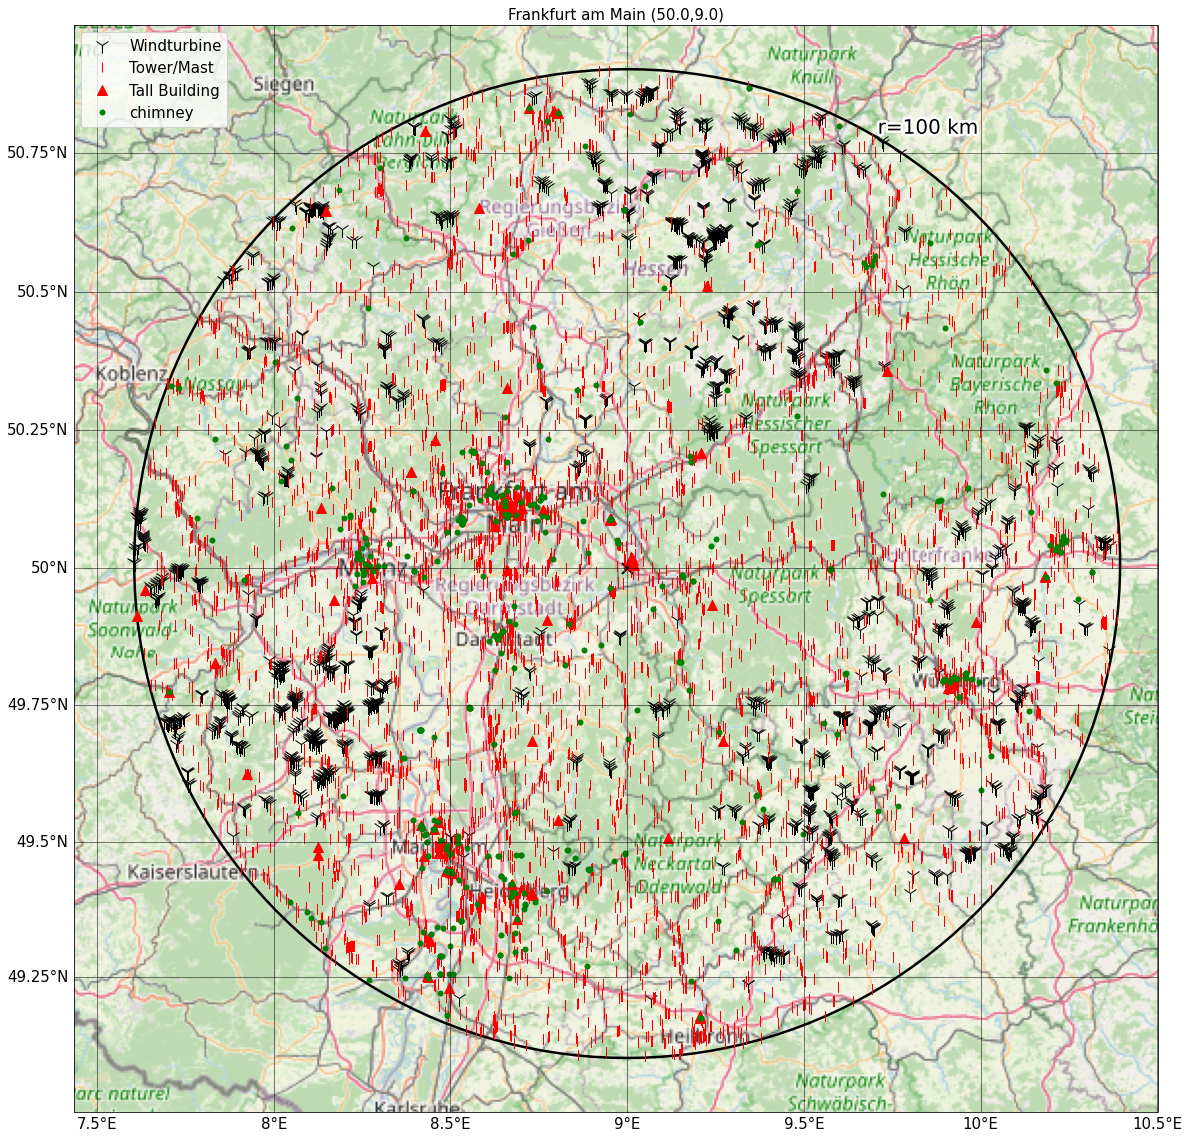

In [202]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

    RADIUS = BLITZ_DIST * 1000
    
    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    osm_image(lon, lat, sitename=sitename, style='map', radius=RADIUS)

    return

##########################################################################

def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    #scale = int(120/np.log(radius))
    scale = int(115/np.log(radius))
    scale = (scale<20) and scale or 19

    scale = 8
    
    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    ax.plot(lon,lat, color='black', marker='x', ms=11, mew=2, transform=data_crs)
    
    ax.plot(windturbines.lon,windturbines.lat,color='black',lw=0,marker='1',ms=15,mew=1.0,transform=data_crs, label='Windturbine')
    #ax.plot(towers.lon,towers.lat,color='red',lw=0,marker='|',ms=10,mew=1.0,transform=data_crs, label='Tower/Mast')
    ax.plot(buildings.lon,buildings.lat,color='red',lw=0,marker='^',ms=10,mew=1.0,transform=data_crs, label='High-raise Building')
    #ax.plot(chimneys.lon,chimneys.lat,color='green',lw=0,marker='.',ms=10,mew=1.0,transform=data_crs, label='chimney')

    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={int(radius/1000)} km', color='black', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
    
    plt.legend(loc=2)

    plt.show()

    fig.savefig(f'./pics/'+sitename+'_windturbines.png', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":
   main()

In [203]:
print('windturbnes', len(windturbines))
print('High rise buildings', len(buildings))
print('Towers/Masts', len(towers))
print('Chimneys', len(chimneys))


windturbnes 1747
High rise buildings 143
Towers/Masts 6943
Chimneys 440


In [204]:
start=pd.Timestamp('2021-1-1') 

# Converting pandas.Series to numpy.array
latRad_windturbines = windturbines['latRad'].to_numpy()
lonRad_windturbines = windturbines['lonRad'].to_numpy()
latRad_towers = towers['latRad'].to_numpy()
lonRad_towers = towers['lonRad'].to_numpy()
latRad_chimneys = chimneys['latRad'].to_numpy()
lonRad_chimneys = chimneys['lonRad'].to_numpy()
latRad_buildings = buildings['latRad'].to_numpy()
lonRad_buildings = buildings['lonRad'].to_numpy()

medians = pd.DataFrame(columns=['day', 'median'])

#for d in range(0,60):
for d in range(0,365*3+160):
    day = start + pd.Timedelta(days=d)
    ifile = '%02d-%02d-%02d.log' % (day.year, day.month, day.day)

    # Load of lightning data
    blitz = pd.read_csv('/storage/blitzortung/2021-2023/region-1/'+ifile, sep=',', low_memory=False, on_bad_lines='skip')
    print(ifile)

    # Reduction of distant lightnings
    blitz['lonRad']=np.radians(blitz.lon)
    blitz['latRad']=np.radians(blitz.lat)
    lonRad=np.radians(lon)
    latRad=np.radians(lat)
    blitz['DlonRad']=lonRad-blitz.lonRad
    blitz['DlatRad']=latRad-blitz.latRad
    blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
    blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
    blitz = blitz.loc[blitz['km'] <= BLITZ_DIST]
    blitz.reset_index(inplace=True)

    if len(blitz)>0:
        # Identify lightning with nearby structures

        # Converting coordinates to radians
        blitz['latRad'] = np.radians(blitz['lat'])
        blitz['lonRad'] = np.radians(blitz['lon'])
        #windturbines['latRad'] = np.radians(windturbines['lat'])
        #windturbines['lonRad'] = np.radians(windturbines['lon'])

        # Converting pandas.Series to numpy.array
        latRad_blitz = blitz['latRad'].to_numpy()
        lonRad_blitz = blitz['lonRad'].to_numpy()
        #latRad_windturbines = windturbines['latRad'].to_numpy()
        #lonRad_windturbines = windturbines['lonRad'].to_numpy()

        # Calculating distance between each point in 'blitz' and all points in 'structures'
        distances_wt = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_windturbines, lonRad_windturbines)
        distances_tw = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_towers, lonRad_towers)
        distances_ch = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_chimneys, lonRad_chimneys)
        distances_bu = vec_haversine(latRad_blitz[:, np.newaxis], lonRad_blitz[:, np.newaxis], latRad_buildings, lonRad_buildings)

        median_wt = round(statistics.median(np.amin(distances_wt, axis=1)),1)
        median_tw = round(statistics.median(np.amin(distances_tw, axis=1)),1)
        median_ch = round(statistics.median(np.amin(distances_ch, axis=1)),1)
        median_bu = round(statistics.median(np.amin(distances_bu, axis=1)),1)
    else:
        median_wt = np.nan
        median_tw = np.nan
        median_ch = np.nan
        median_bu = np.nan
    strokes = len(blitz)
    print(strokes, median_wt, median_tw, median_ch, median_bu)
    #print(strokes, median_wt, median_bu)
    median = pd.DataFrame(data= {'day':[day],'median_wt':[median_wt],'median_tw':[median_tw],'median_ch':[median_ch],'median_bu':[median_bu],'strokes':[strokes]})
    #median = pd.DataFrame(data= {'day':[day],'median_wt':[median_wt],'median_bu':[median_bu],'strokes':[strokes]})
    medians = pd.concat([medians,median])
    

2021-01-01.log
0 nan nan nan nan
2021-01-02.log
0 nan nan nan nan
2021-01-03.log
0 nan nan nan nan
2021-01-04.log
0 nan nan nan nan
2021-01-05.log
0 nan nan nan nan
2021-01-06.log
0 nan nan nan nan
2021-01-07.log
0 nan nan nan nan
2021-01-08.log
0 nan nan nan nan
2021-01-09.log
0 nan nan nan nan
2021-01-10.log
0 nan nan nan nan
2021-01-11.log
0 nan nan nan nan
2021-01-12.log
0 nan nan nan nan
2021-01-13.log
0 nan nan nan nan
2021-01-14.log
2 0.5 1.9 5.4 14.3
2021-01-15.log
0 nan nan nan nan
2021-01-16.log
0 nan nan nan nan
2021-01-17.log
0 nan nan nan nan
2021-01-18.log
0 nan nan nan nan
2021-01-19.log
0 nan nan nan nan
2021-01-20.log
0 nan nan nan nan
2021-01-21.log
0 nan nan nan nan
2021-01-22.log
0 nan nan nan nan
2021-01-23.log
0 nan nan nan nan
2021-01-24.log
0 nan nan nan nan
2021-01-25.log
0 nan nan nan nan
2021-01-26.log
0 nan nan nan nan
2021-01-27.log
0 nan nan nan nan
2021-01-28.log
0 nan nan nan nan
2021-01-29.log
0 nan nan nan nan
2021-01-30.log
0 nan nan nan nan
2021-01-3

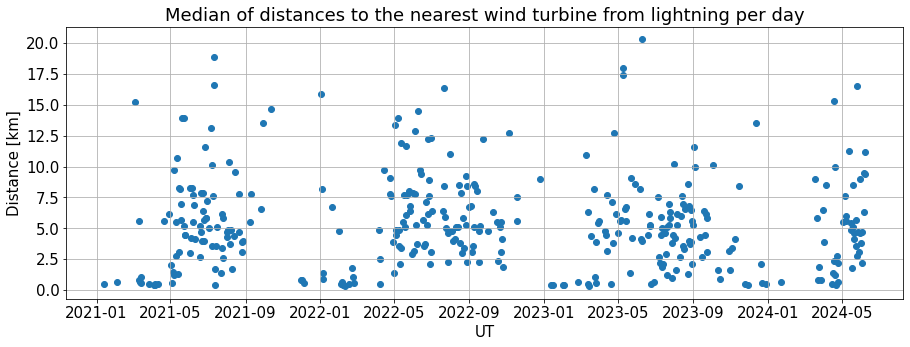

In [58]:
plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 15})
plt.scatter(medians['day'],medians['median'])
plt.ylabel('Distance [km]')
plt.xlabel('UT')
plt.title('Median of distances to the nearest wind turbine from lightning per day')
plt.grid()

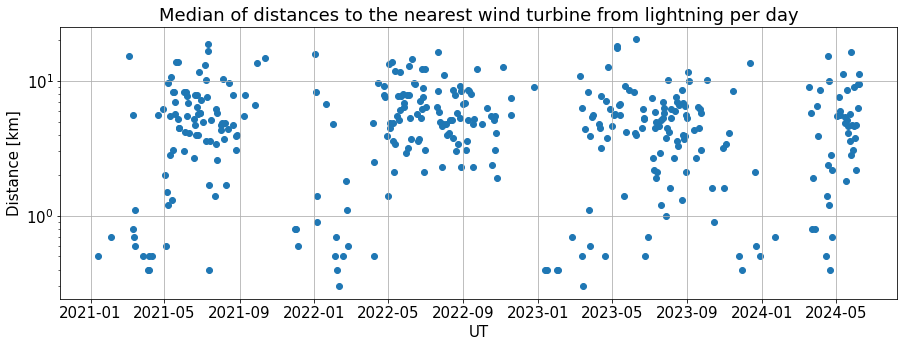

In [59]:
plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 15})
plt.scatter(medians['day'],medians['median'])
plt.ylabel('Distance [km]')
plt.xlabel('UT')
plt.yscale('log')
plt.title('Median of distances to the nearest wind turbine from lightning per day')
plt.grid()

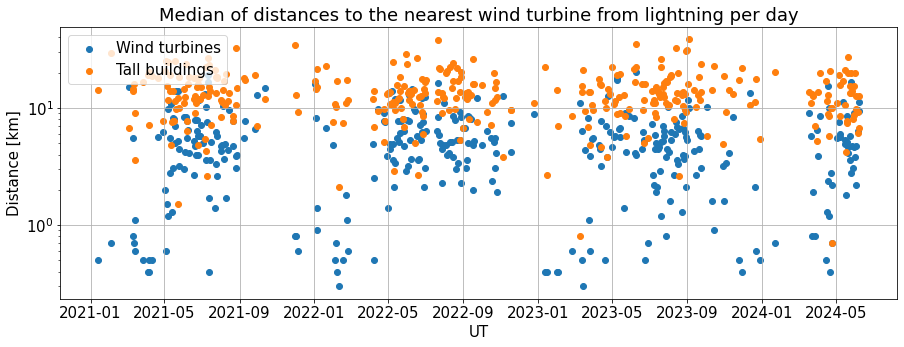

In [207]:
plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 15})
plt.scatter(medians['day'],medians['median_wt'], label='Wind turbines')
plt.scatter(medians['day'],medians['median_bu'], label='Tall buildings')
plt.ylabel('Distance [km]')
plt.xlabel('UT')
plt.yscale('log')
plt.legend(loc=2)
plt.title('Median of distances to the nearest wind turbine from lightning per day')
plt.grid()

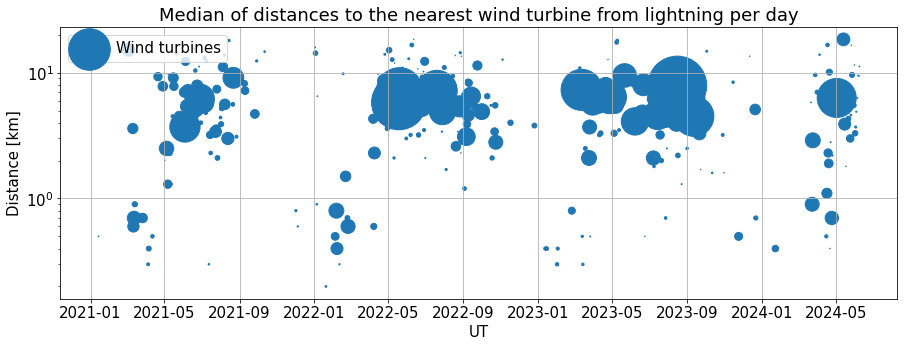

In [189]:
plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 15})
plt.scatter(medians['day'],medians['median_wt'], label='Wind turbines', s=medians['strokes']/3)
plt.ylabel('Distance [km]')
plt.xlabel('UT')
plt.yscale('log')
plt.legend(loc=2)
plt.title('Median of distances to the nearest wind turbine from lightning per day')
plt.grid()

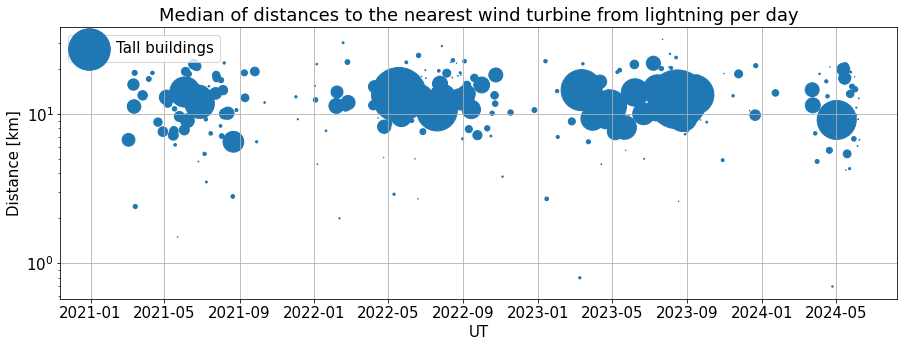

In [190]:
plt.figure(figsize=(15,5))
matplotlib.rcParams.update({'font.size': 15})
plt.scatter(medians['day'],medians['median_bu'], label='Tall buildings', s=medians['strokes']/3)
plt.ylabel('Distance [km]')
plt.xlabel('UT')
plt.yscale('log')
plt.legend(loc=2)
plt.title('Median of distances to the nearest wind turbine from lightning per day')
plt.grid()

In [206]:
medians.to_csv('medians_2021-2024.csv')

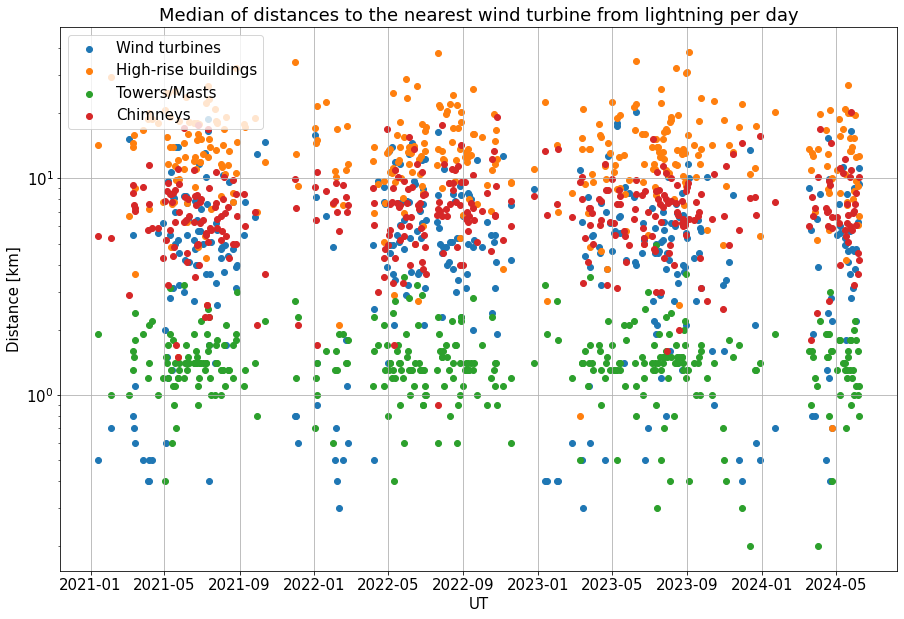

In [210]:
plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 15})
plt.scatter(medians['day'],medians['median_wt'], label='Wind turbines')
plt.scatter(medians['day'],medians['median_bu'], label='High-rise buildings')
plt.scatter(medians['day'],medians['median_tw'], label='Towers/Masts')
plt.scatter(medians['day'],medians['median_ch'], label='Chimneys')
plt.ylabel('Distance [km]')
plt.xlabel('UT')
plt.yscale('log')
plt.legend(loc=2)
plt.title('Median of distances to the nearest wind turbine from lightning per day')
plt.grid()